In [1]:
 !pip install --upgrade pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 9.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import pandas_datareader as web
import talib 
from talib import abstract
plt.style.use('ggplot')

In [38]:
data = web.DataReader("2308.tw", "yahoo", start = "2020-01-01", end = "2022-9-30").round(2)
data.columns = ("high", "low", "open", "close", "volume", "adj_close")
data

,high,low,open,close,volume,adj_close
Date,,,,,,
2020-01-02,152.5,150.5,152.5,151.0,2721085.0,140.57
2020-01-03,152.5,149.0,152.0,151.5,6932546.0,141.04
2020-01-06,151.0,147.5,150.0,149.0,6311505.0,138.71
2020-01-07,151.0,146.5,148.0,149.0,7947026.0,138.71
2020-01-08,149.0,147.0,148.5,148.0,5376586.0,137.78
...,...,...,...,...,...,...
2022-09-26,266.0,258.5,262.0,260.5,5848435.0,260.50
2022-09-27,263.5,259.0,259.5,262.0,4950709.0,262.00
2022-09-28,264.0,252.0,262.0,252.0,6943098.0,252.00


In [39]:
trainData = data[(data.index >= '2020-9-30 00:00:00')].copy()  #樣本內

In [47]:
fund = 1000000
feePaid = 300
length = 50
NumStd = 0.5
EMAT = 20
K = 0.5


trainData['MA'] = trainData['close'].rolling(window= length, center=False).mean()
trainData['STD'] = trainData['close'].rolling(window=length, center=False).std()
trainData['EMA']= talib.EMA(trainData.close, timeperiod = EMAT)
trainData['upLine'] = trainData['MA'] + NumStd*trainData['STD']
trainData['downLine'] = trainData['MA'] - NumStd*trainData['STD']
trainData['ADX'] = talib.ADX(trainData.high, trainData.low, trainData.close, timeperiod=14)

trainData

,high,low,open,close,volume,adj_close,MA,STD,EMA,upLine,downLine,ADX
Date,,,,,,,,,,,,
2020-09-30,189.5,185.5,187.5,189.0,5363374.0,181.30,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-05,192.0,188.0,189.0,189.5,8077771.0,181.78,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-06,191.5,188.5,190.5,191.5,5266598.0,183.70,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-07,192.0,189.0,192.0,191.0,5769108.0,183.22,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-08,193.0,190.5,193.0,193.0,5057573.0,185.14,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,266.0,258.5,262.0,260.5,5848435.0,260.50,262.94,7.944090,265.604849,266.912045,258.967955,15.264664
2022-09-27,263.5,259.0,259.5,262.0,4950709.0,262.00,263.28,7.512683,265.261530,267.036342,259.523658,16.065574
2022-09-28,264.0,252.0,262.0,252.0,6943098.0,252.00,263.40,7.275203,263.998527,267.037601,259.762399,17.715699


In [41]:
df = trainData 

            profit  profitfee
Date                         
2020-09-30     0.0        0.0
2020-10-05     0.0        0.0
2020-10-06     0.0        0.0
2020-10-07     0.0        0.0
2020-10-08     0.0        0.0
...            ...        ...
2022-09-26    10.0   -16190.0
2022-09-27     7.5   -16792.5
2022-09-28     7.5   -16792.5
2022-09-29    15.5   -16784.5
2022-09-30    24.5   -17375.5

[489 rows x 2 columns]


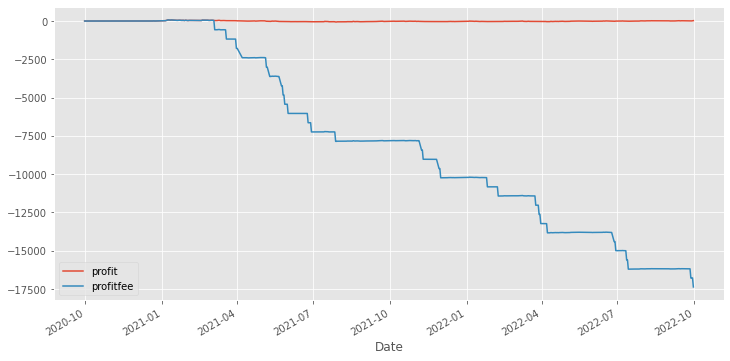

In [42]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df)):

    if i == len(df)-1:
        break

    ## 進場邏輯
    entryLong =  df['close'][i] > df["upLine"][i]
    entrySellShort = df['close'][i] < df["upLine"][i]
    
    ## 出場邏輯
    exitShort = df['close'][i] < df['MA'][i]
    exitBuyToCover = df['close'][i] > df['MA'][i]
    
    ## 停利停損邏輯
    if BS == "B":
      stopLoss = df['close'][i] <= df['open'][t] * (1-K)
      stopProfit = df['close'][i] >= df['open'][t] * (1+K)
    elif BS == 'S':
      stopLoss = df['close'][i] >= df['open'][t] * (1+K)
      stopProfit = df['close'][i] <= df['open'][t] * (1-K)

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort:
            BS = 'S'
            t = i+1
            sellshort.append(t)

        
    elif BS == 'B':
        profit = df['open'][i+1] - df['open'][i]
        profit_list.append(profit)
            
        if exitShort or i == len(df)-2 or stopLoss or stopProfit:
            pl_round = df['open'][i+1] - df['open'][t]
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = df['open'][i] - df['open'][i+1]
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df)-2 or stopLoss or stopProfit:
            pl_round = (df['open'][t] - df['open'][i+1])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=df.index)
print(equity)
equity.plot(grid=True, figsize=(12, 6));

In [43]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

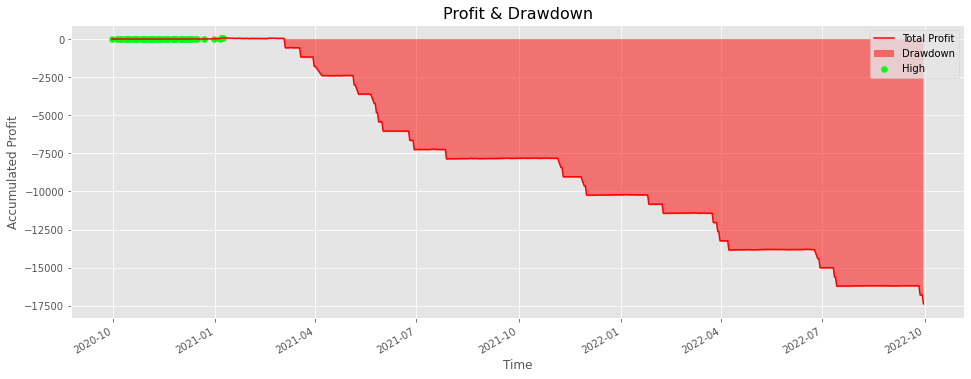

In [44]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

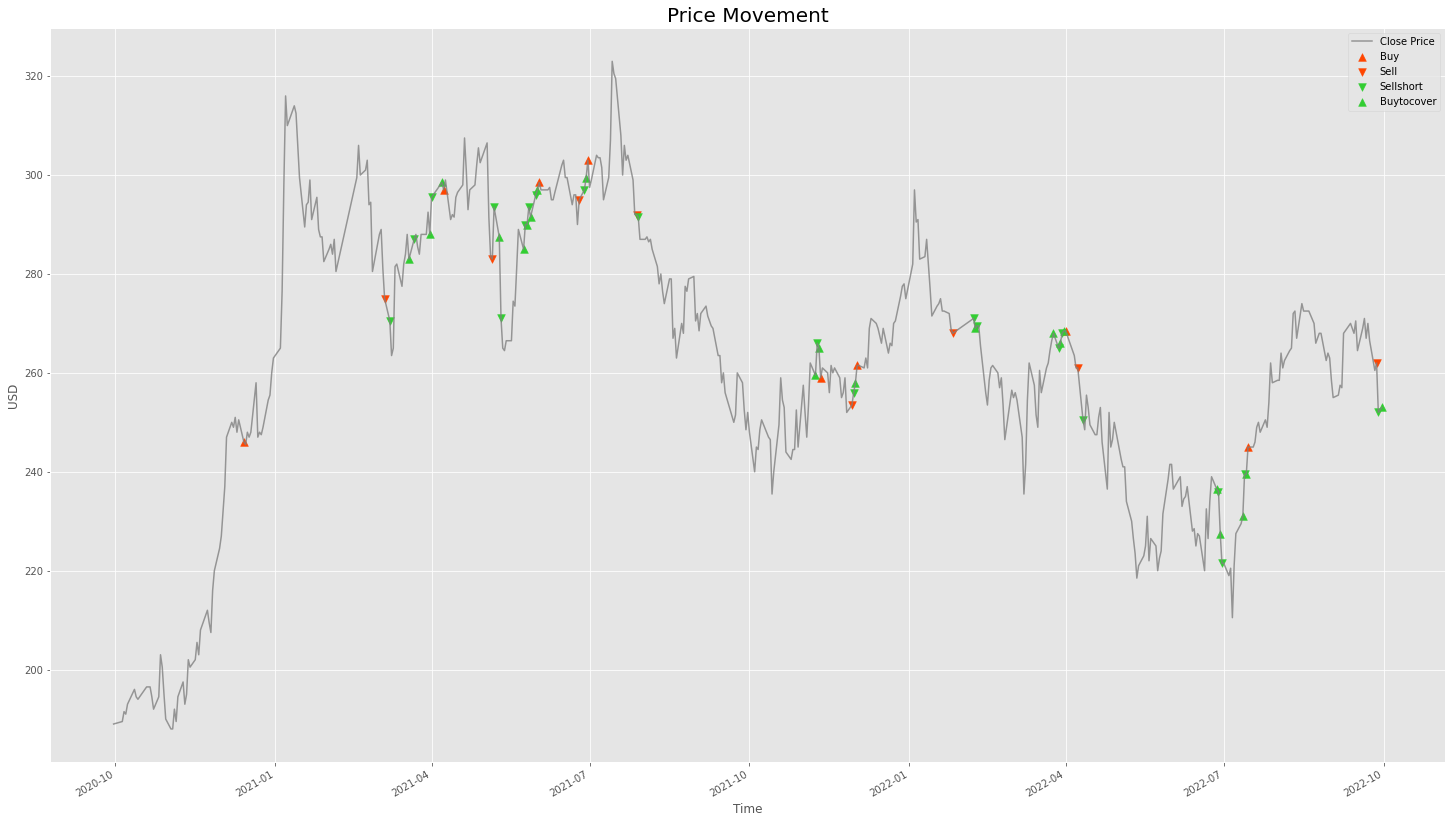

In [45]:
fig, ax = plt.subplots(figsize = (25,15))

df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df['close'].iloc[sellshort].index, df['close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 20);

In [46]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $-17375.5
return: -1.7399999999999998%
mdd: 1.7399999999999998%
calmarRatio: -1.0
tradeTimes: 29
winRate: 0.0%
profitFactor: 0.0
winLossRatio: nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [50]:
optimizationList = []

fund = 1000000
feePaid = 300
k = 0.5
#NumStd = 1.5
#EMAT = 100


for length in range(10,120,10):
  for NumStd in np.arange(0.5, 3, 0.5):

        NumStd = np.round(NumStd,1)
        
        print('----------')
        print(f'length: {length}')
        print(f'NumStd: {NumStd}')
        


        trainData['MA'] = trainData['close'].rolling(window=length, center=False).mean()
        trainData['STD'] = trainData['close'].rolling(window=length, center=False).std()
        trainData['upLine'] = trainData['MA'] + NumStd * trainData['STD']
        trainData['downLine'] = trainData['MA'] - NumStd * trainData['STD']

        BS = None
        buy = []
        sell = []
        sellshort = []
        buytocover = []
        profit_list = [0]
        profit_fee_list = [0]
        profit_fee_list_realized = []
      
        for i in range(len(df)):

            if i == len(df)-1:
                break

            ## 進場邏輯
            entryLong =  df['close'][i] > df["upLine"][i]
            entrySellShort = df['close'][i] < df["upLine"][i]
            
            
            ## 出場邏輯
            exitShort = df['close'][i] < df['MA'][i]
            exitBuyToCover = df['close'][i] > df['MA'][i]
            
            ## 停利停損邏輯
            if BS == "B":
              stopLoss = df['close'][i] <= df['open'][t] * (1-K)
              stopProfit = df['close'][i] >= df['open'][t] * (1+K)
            elif BS == 'S':
              stopLoss = df['close'][i] >= df['open'][t] * (1+K)
              stopProfit = df['close'][i] <= df['open'][t] * (1-K)

            if BS == None:
                profit_list.append(0)
                profit_fee_list.append(0)
                
                if entryLong:
                    BS = 'B'
                    t = i+1
                    buy.append(t)

                elif entrySellShort:
                    BS = 'S'
                    t = i+1
                    sellshort.append(t)

                
            elif BS == 'B':
                profit = 200 * (df['open'][i+1] - df['open'][i])
                profit_list.append(profit)
                    
                if exitShort or i == len(df)-2 or stopLoss or stopProfit:
                    pl_round = (df['open'][i+1] - df['open'][t])
                    profit_fee = profit - feePaid*2
                    profit_fee_list.append(profit_fee)
                    sell.append(i+1)
                    BS=None

                    # Realized PnL
                    profit_fee_realized = pl_round - feePaid*2
                    profit_fee_list_realized.append(profit_fee_realized)

                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)
                    
            elif BS == 'S': 
                profit = (df['open'][i] - df['open'][i+1])
                profit_list.append(profit)
                
                if exitBuyToCover or i == len(df)-2 or stopLoss or stopProfit:
                    pl_round = (df['open'][t] - df['open'][i+1])
                    profit_fee = profit - feePaid*2
                    profit_fee_list.append(profit_fee)
                    buytocover.append(i+1)
                    BS=None

                    # Realized PnL
                    profit_fee_realized = pl_round - feePaid*2
                    profit_fee_list_realized.append(profit_fee_realized)

                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)


        equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
        equity['equity'] = equity['profitfee'] + fund
        equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
        equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
        ret = equity['equity'][-1]/equity['equity'][0] - 1
        mdd = abs(equity['drawdown_percent'].min())
        calmarRatio = ret / mdd
        
        optimizationList.append([ EMAT, NumStd, ret, calmarRatio])

----------
length: 10
NumStd: 0.5
----------
length: 10
NumStd: 1.0
----------
length: 10
NumStd: 1.5
----------
length: 10
NumStd: 2.0
----------
length: 10
NumStd: 2.5
----------
length: 20
NumStd: 0.5
----------
length: 20
NumStd: 1.0
----------
length: 20
NumStd: 1.5
----------
length: 20
NumStd: 2.0
----------
length: 20
NumStd: 2.5
----------
length: 30
NumStd: 0.5
----------
length: 30
NumStd: 1.0
----------
length: 30
NumStd: 1.5
----------
length: 30
NumStd: 2.0
----------
length: 30
NumStd: 2.5
----------
length: 40
NumStd: 0.5
----------
length: 40
NumStd: 1.0
----------
length: 40
NumStd: 1.5
----------
length: 40
NumStd: 2.0
----------
length: 40
NumStd: 2.5
----------
length: 50
NumStd: 0.5
----------
length: 50
NumStd: 1.0
----------
length: 50
NumStd: 1.5
----------
length: 50
NumStd: 2.0
----------
length: 50
NumStd: 2.5
----------
length: 60
NumStd: 0.5
----------
length: 60
NumStd: 1.0
----------
length: 60
NumStd: 1.5
----------
length: 60
NumStd: 2.0
----------
len

In [54]:
optResult = pd.DataFrame(optimizationList, columns=["length", "NumStd", 'ret', 'calmarRatio'])
optResult

,length,NumStd,ret,calmarRatio
0,20,0.5,-0.034335,-0.692099
1,20,1.0,-0.044941,-0.801443
2,20,1.5,-0.064031,-0.920182
3,20,2.0,-0.090068,-1.000000
4,20,2.5,-0.087856,-1.000000
5,20,0.5,-0.036026,-0.716846
6,20,1.0,-0.040548,-0.722632
7,20,1.5,-0.045335,-0.745380
8,20,2.0,-0.069761,-0.997652
9,20,2.5,-0.073395,-1.000000


In [53]:
optResult[(optResult['length'] == 1.5)].sort_values('ret', ascending=False).iloc[:5]

KeyError: ignored